
#  Análise de Entregas e Satisfação do Cliente — Olist

**Objetivo:** analisar o impacto de **atrasos de entrega** sobre a **satisfação do cliente** (notas de avaliação) e evidenciar **diferenças regionais/estaduais**.

## Sumário
1. [Carregamento e Preparação dos Dados](#1-carregamento-e-preparação-dos-dados)  
2. [Qualidade dos Dados (Nulos e Duplicados)](#2-qualidade-dos-dados-nulos-e-duplicados)  
3. [Criação da Variável de Atraso](#3-criação-da-variável-de-atraso)  
4. [Análises Descritivas](#4-análises-descritivas)  
5. [Relação entre Atraso e Nota](#5-relação-entre-atraso-e-nota)  
6. [Correlação e Regressão Linear](#6-correlação-e-regressão-linear)  
7. [Análise Geográfica (Estado e Região)](#7-análise-geográfica-estado-e-região)  
8. [Conclusões e Recomendações](#8-conclusões-e-recomendações)  
9. [Apêndice — Funções Utilitárias](#9-apêndice--funções-utilitárias)  


## 1. Carregamento e Preparação dos Dados

In [7]:

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np

sns.set(style="whitegrid")


In [11]:

# Definir caminho (ajuste para sua máquina)
path = "C:/Users/orfeu/Desktop/Projeto-E-commerce-Olist/data"

# Leitura dos datasets principais
orders = pd.read_csv(os.path.join(path, 'olist_orders_dataset.csv'))
df_reviews = pd.read_csv(os.path.join(path, 'olist_order_reviews_dataset.csv'))
customers = pd.read_csv(os.path.join(path, 'olist_customers_dataset.csv'))


In [13]:

# Conversão de colunas de data
date_columns = [
    'order_purchase_timestamp','order_approved_at',
    'order_delivered_carrier_date','order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for col in date_columns:
    orders[col] = pd.to_datetime(orders[col])

df_reviews['review_creation_date'] = pd.to_datetime(df_reviews['review_creation_date'])
df_reviews['review_answer_timestamp'] = pd.to_datetime(df_reviews['review_answer_timestamp'])
print('===  Tabela Orders ===')
display(orders.head(3))
print('===  Tabela Reviews ===')
display(df_reviews.head(3))


===  Tabela Orders ===


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


===  Tabela Reviews ===


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24


## 2. Qualidade dos Dados (Nulos e Duplicados)

In [15]:

def resumo_dataset(df, nome=""):
    resumo = pd.DataFrame({
        'Não Nulos': df.notnull().sum(),
        'Nulos': df.isnull().sum(),
        '% Completude': (df.notnull().mean() * 100).round(1)
    })
    resumo['Duplicados'] = df.duplicated().sum()
    print(f"=== {nome} ===")
    display(resumo)

resumo_dataset(orders, "Orders")
resumo_dataset(df_reviews, "Reviews")


=== Orders ===


,Não Nulos,Nulos,% Completude,Duplicados
order_id,99441,0,100.0,0
customer_id,99441,0,100.0,0
order_status,99441,0,100.0,0
order_purchase_timestamp,99441,0,100.0,0
order_approved_at,99281,160,99.8,0
order_delivered_carrier_date,97658,1783,98.2,0
order_delivered_customer_date,96476,2965,97.0,0
order_estimated_delivery_date,99441,0,100.0,0


=== Reviews ===


,Não Nulos,Nulos,% Completude,Duplicados
review_id,99224,0,100.0,0
order_id,99224,0,100.0,0
review_score,99224,0,100.0,0
review_comment_title,11568,87656,11.7,0
review_comment_message,40977,58247,41.3,0
review_creation_date,99224,0,100.0,0
review_answer_timestamp,99224,0,100.0,0


## 3. Criação da Variável de Atraso

In [17]:

orders_validas = orders[orders['order_delivered_customer_date'].notna()].copy()
orders_validas['atraso_dias'] = (
    orders_validas['order_delivered_customer_date'] - orders_validas['order_estimated_delivery_date']
).dt.days
orders_validas['atrasado'] = orders_validas['atraso_dias'] > 0

display(orders_validas[['order_id','atraso_dias','atrasado']].head())


,order_id,atraso_dias,atrasado
0,e481f51cbdc54678b7cc49136f2d6af7,-8,False
1,53cdb2fc8bc7dce0b6741e2150273451,-6,False
2,47770eb9100c2d0c44946d9cf07ec65d,-18,False
3,949d5b44dbf5de918fe9c16f97b45f8a,-13,False
4,ad21c59c0840e6cb83a9ceb5573f8159,-10,False


## 4. Análises Descritivas

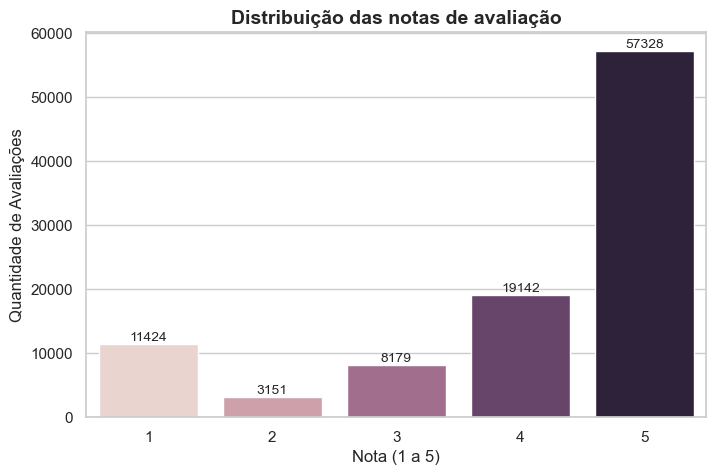

In [23]:
# Gráfico de distribuição das notas
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='review_score', data=df_reviews, hue='review_score', legend=False)
plt.title('Distribuição das notas de avaliação', fontsize=14, fontweight='bold')
plt.xlabel('Nota (1 a 5)')
plt.ylabel('Quantidade de Avaliações')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10)
plt.savefig('../images/distribuicao_notas.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

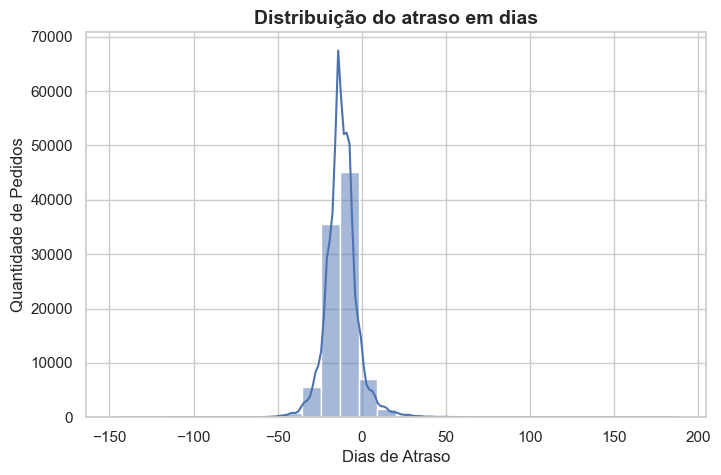

In [25]:

plt.figure(figsize=(8, 5))
sns.histplot(orders_validas['atraso_dias'], bins=30, kde=True)
plt.title('Distribuição do atraso em dias', fontsize=14, fontweight='bold')
plt.xlabel('Dias de Atraso')
plt.savefig('../images/distribuicao_atraso_dias.png', dpi=300, bbox_inches='tight')
plt.ylabel('Quantidade de Pedidos')
plt.show()
plt.close()

## 5. Relação entre Atraso e Nota

In [29]:

df_entregas_reviews = pd.merge(orders_validas, df_reviews, on='order_id', how='inner')


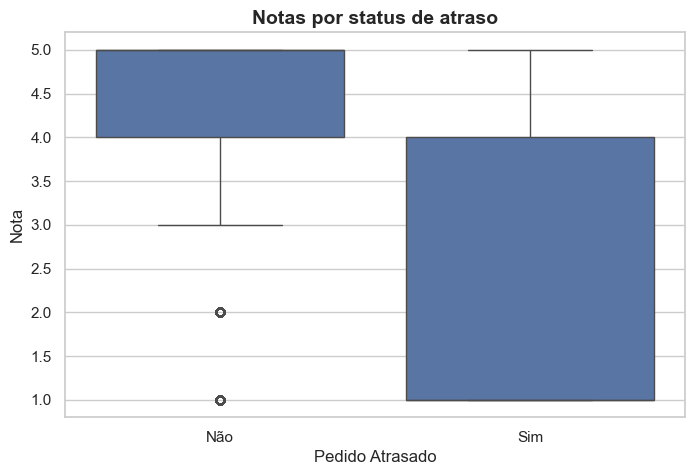

In [31]:

plt.figure(figsize=(8, 5))
sns.boxplot(x='atrasado', y='review_score', data=df_entregas_reviews)
plt.title('Notas por status de atraso', fontsize=14, fontweight='bold')
plt.xlabel('Pedido Atrasado')
plt.ylabel('Nota')
plt.xticks([0, 1], ['Não', 'Sim'])
plt.savefig('../images/notas_status_atraso.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


,atrasado,review_score
0,Não,4.289842
1,Sim,2.271139


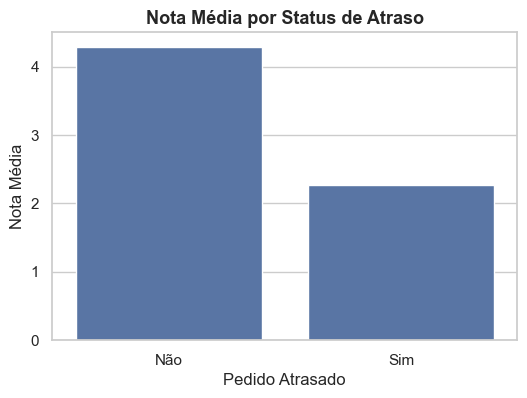

In [35]:

nota_media = df_entregas_reviews.groupby('atrasado')['review_score'].mean().reset_index()
nota_media['atrasado'] = nota_media['atrasado'].map({False: 'Não', True: 'Sim'})
display(nota_media)

plt.figure(figsize=(6, 4))
sns.barplot(x='atrasado', y='review_score', data=nota_media)
plt.title('Nota Média por Status de Atraso', fontsize=13, fontweight='bold')
plt.xlabel('Pedido Atrasado')
plt.ylabel('Nota Média')
plt.savefig('../images/nota_media_por_status_de_atraso.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Correlação e Regressão Linear

Correlação (Pearson): -0.267 | Valor-p: 0.00000


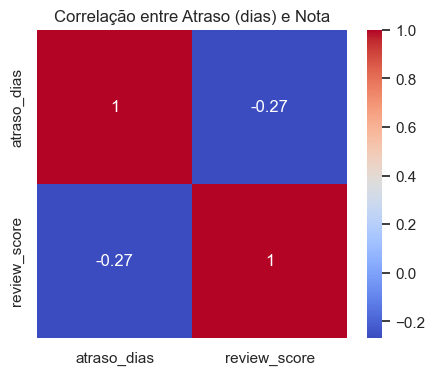

In [39]:

corr, p_value = pearsonr(
    df_entregas_reviews['atraso_dias'].dropna(),
    df_entregas_reviews['review_score'].dropna()
)
print(f"Correlação (Pearson): {corr:.3f} | Valor-p: {p_value:.5f}")

plt.figure(figsize=(5,4))
sns.heatmap(df_entregas_reviews[['atraso_dias','review_score']].corr(), annot=True, cmap="coolwarm")
plt.title('Correlação entre Atraso (dias) e Nota')
plt.savefig('../images/correlaçao.png', dpi=300, bbox_inches='tight')
plt.show()


Regressão Linear: Nota = 3.75 + (-0.034 * atraso_dias)
→ Cada dia de atraso reduz a nota média em aproximadamente 0.034 pontos.


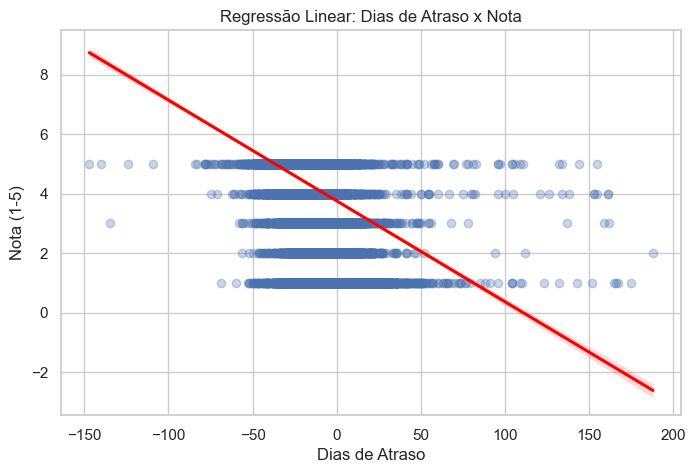

In [47]:

X = df_entregas_reviews[['atraso_dias']].fillna(0)
y = df_entregas_reviews['review_score'].fillna(df_entregas_reviews['review_score'].mean())

model = LinearRegression()
model.fit(X, y)

coef = model.coef_[0]
intercepto = model.intercept_
print(f"Regressão Linear: Nota = {intercepto:.2f} + ({coef:.3f} * atraso_dias)")
print(f"→ Cada dia de atraso reduz a nota média em aproximadamente {abs(coef):.3f} pontos.")

plt.figure(figsize=(8, 5))
sns.regplot(x='atraso_dias', y='review_score', data=df_entregas_reviews, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Regressão Linear: Dias de Atraso x Nota')
plt.xlabel('Dias de Atraso')
plt.ylabel('Nota (1-5)')
plt.savefig('../images/regressão.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Análise Geográfica (Estado e Região)

In [50]:

df_entregas_reviews = df_entregas_reviews.merge(
    customers[['customer_id','customer_state']],
    on='customer_id', how='left'
)


In [52]:

atraso_estado = df_entregas_reviews.groupby('customer_state')['atrasado'].mean().sort_values(ascending=False)
display(atraso_estado.head(10).rename('Percentual de atrasos (Top 10)'))


customer_state
AL    0.208543
MA    0.170391
SE    0.149701
PI    0.137712
CE    0.137147
RR    0.121951
BA    0.119532
RJ    0.119179
PA    0.106496
ES    0.103640
Name: Percentual de atrasos (Top 10), dtype: float64

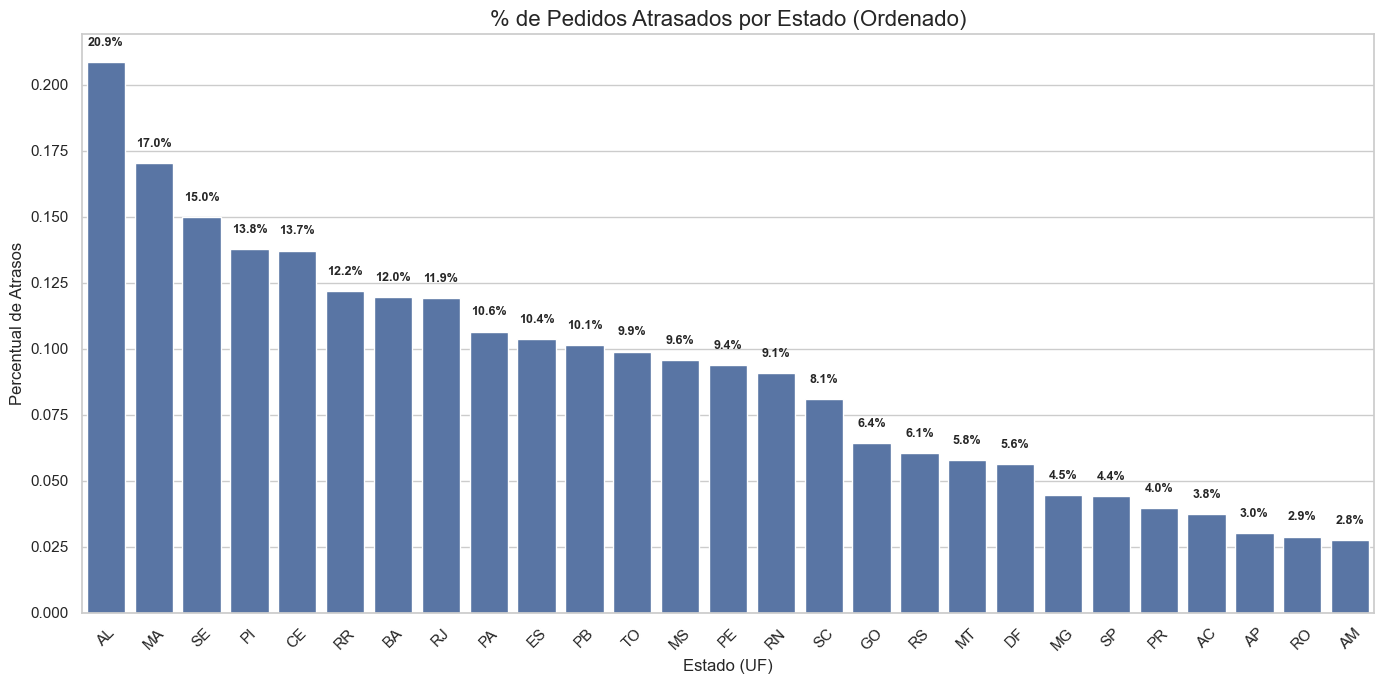

In [56]:

plt.figure(figsize=(14, 7))
sns.barplot(x=atraso_estado.index, y=atraso_estado.values)
plt.title('% de Pedidos Atrasados por Estado (Ordenado)', fontsize=16)
plt.xlabel('Estado (UF)')
plt.ylabel('Percentual de Atrasos')
plt.xticks(rotation=45)
for i, value in enumerate(atraso_estado.values):
    plt.text(i, value + 0.005, f'{value:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/pedidos_atrasados_por_estado.png', dpi=300, bbox_inches='tight')
plt.show()


In [58]:

nota_estado = df_entregas_reviews.groupby('customer_state')['review_score'].mean().sort_values()
display(nota_estado.rename('Nota Média por Estado'))


customer_state
MA    3.839385
AL    3.841709
RR    3.902439
SE    3.907186
PA    3.912673
BA    3.929452
CE    3.938088
RJ    3.962716
PI    3.995763
PB    4.077973
ES    4.082406
PE    4.085535
AC    4.087500
GO    4.102904
SC    4.130164
DF    4.131642
MT    4.147392
RN    4.150106
TO    4.153846
RO    4.165289
MS    4.169014
RS    4.185344
MG    4.192602
AM    4.220690
PR    4.238260
AP    4.242424
SP    4.246183
Name: Nota Média por Estado, dtype: float64

In [62]:
#agrupando estados em regiões
regioes = {
    'AC': 'Norte','AL': 'Nordeste','AP': 'Norte','AM': 'Norte','BA': 'Nordeste',
    'CE': 'Nordeste','DF': 'Centro-Oeste','ES': 'Sudeste','GO': 'Centro-Oeste',
    'MA': 'Nordeste','MT': 'Centro-Oeste','MS': 'Centro-Oeste','MG': 'Sudeste',
    'PA': 'Norte','PB': 'Nordeste','PR': 'Sul','PE': 'Nordeste','PI': 'Nordeste',
    'RJ': 'Sudeste','RN': 'Nordeste','RS': 'Sul','RO': 'Norte','RR': 'Norte',
    'SC': 'Sul','SP': 'Sudeste','SE': 'Nordeste','TO': 'Norte'
}
df_entregas_reviews['regiao'] = df_entregas_reviews['customer_state'].map(regioes)

#atraso por região
atraso_regiao = df_entregas_reviews.groupby('regiao')['atrasado'].mean().sort_values(ascending=False)
display(atraso_regiao.rename('% Atrasos por Região'))


regiao
Nordeste        0.124972
Norte           0.082867
Centro-Oeste    0.064316
Sudeste         0.060005
Sul             0.058338
Name: % Atrasos por Região, dtype: float64

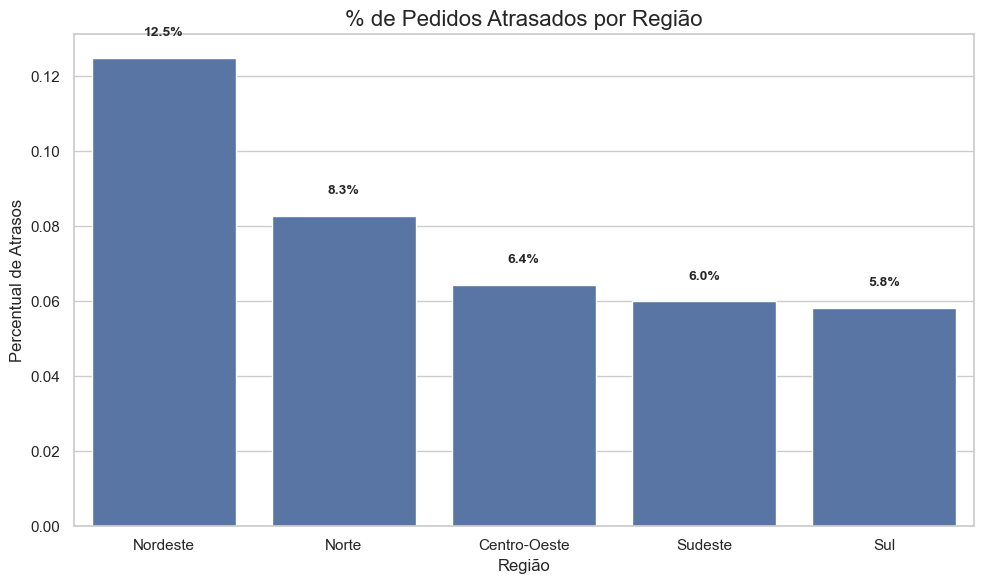

In [64]:
#grafico para porcentagem de pedidos atrasados por regiao
plt.figure(figsize=(10, 6))
sns.barplot(x=atraso_regiao.index, y=atraso_regiao.values)
plt.title('% de Pedidos Atrasados por Região', fontsize=16)
plt.xlabel('Região')
plt.ylabel('Percentual de Atrasos')
for i, value in enumerate(atraso_regiao.values):
    plt.text(i, value + 0.005, f'{value:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/pedidos_atrsados_por_regiao.png', dpi=300, bbox_inches='tight')
plt.show()


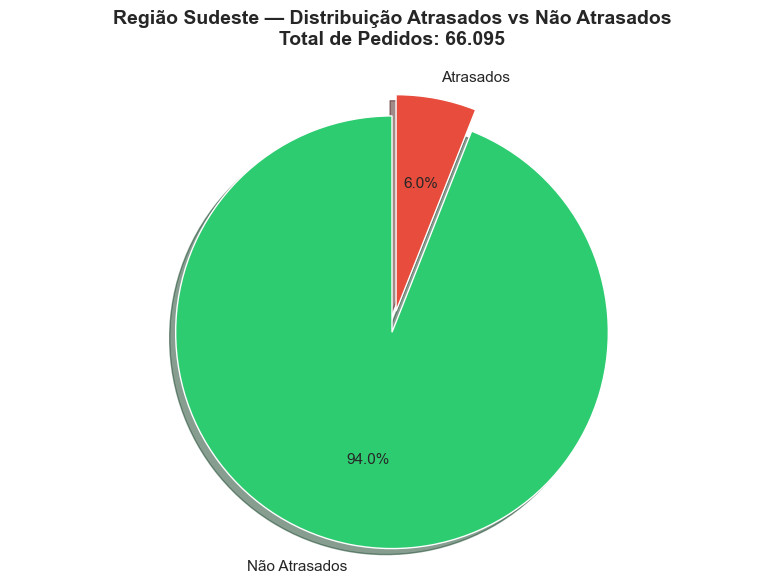

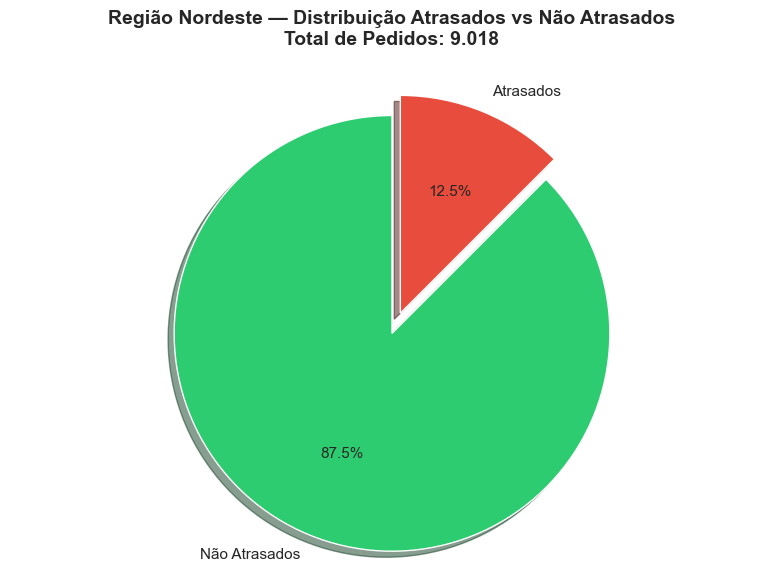

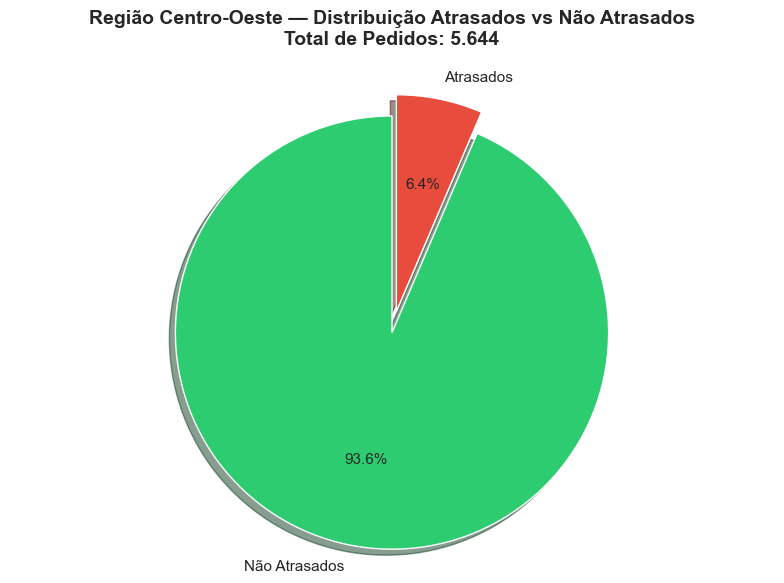

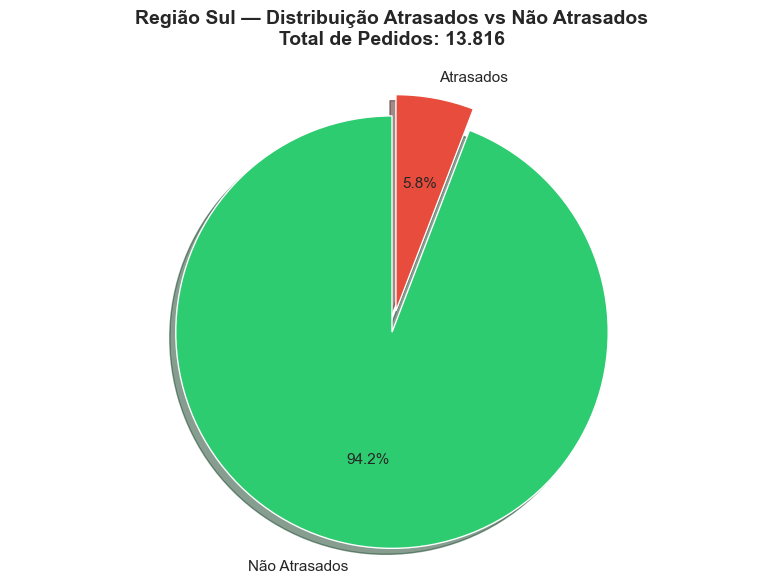

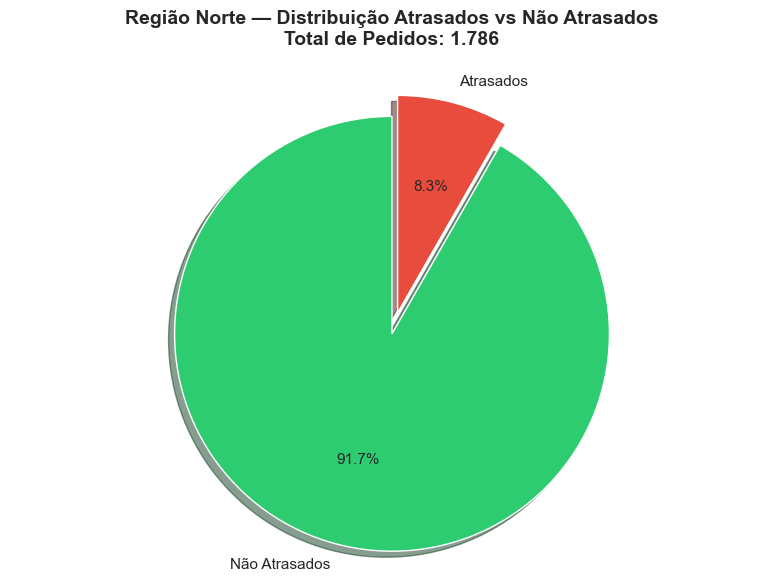

In [66]:
#graficos de pizza para melhor visualizar o estado de cada região

for regiao in df_entregas_reviews['regiao'].dropna().unique():
    df_r = df_entregas_reviews[df_entregas_reviews['regiao'] == regiao]
    contagem = df_r['atrasado'].value_counts()
    labels = ['Não Atrasados', 'Atrasados']
    sizes = [contagem.get(False, 0), contagem.get(True, 0)]
    colors = ['#2ecc71', '#e74c3c']
    explode = (0, 0.1)

    plt.figure(figsize=(8, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 11})
    plt.title(f'Região {regiao} — Distribuição Atrasados vs Não Atrasados\n' +
              f'Total de Pedidos: {len(df_r):,}'.replace(",", "."),
              fontsize=14, fontweight='bold', pad=20)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()



## 8. Conclusões e Recomendações



